In [41]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

column_names=["Left Angle","Right Angle"]
df1 = pd.read_csv("../test/exp1_agk_dist_phone_05_23.csv", names=column_names)
df2 = pd.read_csv("../test/exp2_agk_dist_phone_05_23.csv", names=column_names)
df3 = pd.read_csv("../test/exp3_agk_dist_phone_05_23.csv", names=column_names)

df1.head()

,Left Angle,Right Angle
0,-48.794917,43.597754
1,-48.160957,43.703937
2,-48.160957,43.544522
3,-48.343708,43.597754
4,-48.160957,45.552352


In [43]:
import numpy as np

vid_fps = 30
dt = 1/vid_fps

time = np.arange(0, df1.shape[0] * dt, dt)
df1['Time'] = time
time = np.arange(0, df2.shape[0] * dt, dt)
df2['Time'] = time
time = np.arange(0, df3.shape[0] * dt, dt)
df3['Time'] = time

In [44]:
df1[column_names[0]] = df1[column_names[0]] * -1
df2[column_names[0]] = df2[column_names[0]] * -1
df3[column_names[0]] = df3[column_names[0]] * -1

<Axes: xlabel='Time'>

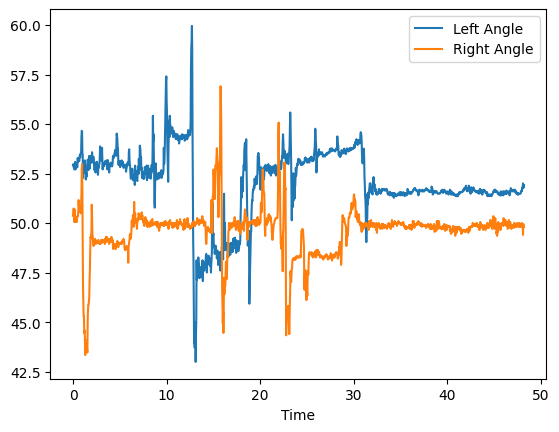

In [47]:
df1.plot('Time', ['Left Angle', 'Right Angle'])

df2.plot('Time', ['Left Angle', 'Right Angle'])

df3.plot('Time', ['Left Angle', 'Right Angle'])
